# Results - Regression on Real-world Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_regression_results.ipynb)

## Prerequisites

In [1]:
%load_ext rich
%load_ext autoreload
%autoreload 2
%matplotlib inline

from rich import print

random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_metrics_bar,
    get_metrics_summary,
    plot_cv_indices,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_synth_regression_scoring, SHM_Scoring

from bench_utils import extract_metrics

## Data Loading

In [4]:
base = "s20_synthetic_regression_AB_dssize.pkl"
base = Path(RESULT_PATH, base)

base = pd.read_pickle(base)

In [5]:
res = "s30_synthetic_regression_AB_featsel_cc.pkl"
res = Path(RESULT_PATH, res)

res = pd.read_pickle(res)

### Combine results from baseline and our models

In [6]:
results = pd.concat(
    [
        base[(base["model"] == "BASE") | (base["model"] == "ClusterCentroids_2")],
        res[(res["model"] != "BASE") & (res["model"] != "ClusterCentroids")],
    ],
    ignore_index=True,
)

In [7]:
# source columns
shm_scoring = SHM_Scoring()

mse_individual = ["test_mse_0.0"] + shm_scoring.SYNTH_MSE_RESULTS
mse_individual


[
    'test_mse_0.0',
    'test_mse_2.2',
    'test_mse_2.5',
    'test_mse_2.8',
    'test_mse_3.1',
    'test_mse_3.4',
    'test_mse_3.8',
    'test_mse_4.1',
    'test_mse_4.4',
    'test_mse_4.7',
    'test_mse_5.0',
    'test_mse_6.7',
    'test_mse_8.3',
    'test_mse_10.0',
    'test_mse_12.0',
    'test_mse_14.0',
    'test_mse_16.0',
    'test_mse_18.0',
    'test_mse_20.0',
    'test_mse_22.0',
    'test_mse_24.0',
    'test_mse_26.0',
    'test_mse_28.0',
    'test_mse_30.0',
    'test_mse_32.0',
    'test_mse_34.0',
    'test_mse_36.0',
    'test_mse_38.0',
    'test_mse_40.0'
]

In [8]:
# target columns
mse_contr_individual = [
    item.replace("test_mse_", "mse_contr_") for item in mse_individual
]
mse_contr_individual


[
    'mse_contr_0.0',
    'mse_contr_2.2',
    'mse_contr_2.5',
    'mse_contr_2.8',
    'mse_contr_3.1',
    'mse_contr_3.4',
    'mse_contr_3.8',
    'mse_contr_4.1',
    'mse_contr_4.4',
    'mse_contr_4.7',
    'mse_contr_5.0',
    'mse_contr_6.7',
    'mse_contr_8.3',
    'mse_contr_10.0',
    'mse_contr_12.0',
    'mse_contr_14.0',
    'mse_contr_16.0',
    'mse_contr_18.0',
    'mse_contr_20.0',
    'mse_contr_22.0',
    'mse_contr_24.0',
    'mse_contr_26.0',
    'mse_contr_28.0',
    'mse_contr_30.0',
    'mse_contr_32.0',
    'mse_contr_34.0',
    'mse_contr_36.0',
    'mse_contr_38.0',
    'mse_contr_40.0'
]

In [9]:
results

,fit_time,score_time,estimator,test_r2 avg,test_neg_mean_squared_error avg,test_r2_0.0,test_r2_2.8,test_r2_3.1,test_r2_3.4,test_r2_3.8,...,test_abs_err_22.0,test_abs_err_24.0,test_abs_err_26.0,test_abs_err_28.0,test_abs_err_30.0,test_abs_err_32.0,test_abs_err_34.0,test_abs_err_36.0,test_abs_err_38.0,test_abs_err_40.0
0,0.065054,0.155914,(FunctionTransformer(func=<function _to_numpy ...,0.999971,-0.004599,1.0,-1.071035e+29,-1.075582e+28,-4.417174e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.067220,0.171195,(FunctionTransformer(func=<function _to_numpy ...,0.999970,-0.004684,1.0,-9.313351e+28,-6.658367e+27,-2.665987e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.060321,0.155736,(FunctionTransformer(func=<function _to_numpy ...,0.999976,-0.003787,1.0,-7.450681e+28,-9.219277e+27,-2.051764e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.009361,0.060657,(FunctionTransformer(func=<function _to_numpy ...,0.999966,-0.005408,1.0,-1.117602e+29,-1.229237e+28,-3.920569e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008843,0.051212,(FunctionTransformer(func=<function _to_numpy ...,0.999975,-0.003953,1.0,-9.779019e+28,-1.075582e+28,-3.293278e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.167376,0.045976,"(SelectKBest(k=27, score_func=<function r_regr...",0.999837,-0.025814,0.0,-4.191008e+29,-4.524275e+28,-8.769006e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
348,0.202705,0.044915,"(SelectKBest(k=27, score_func=<function r_regr...",0.999778,-0.035111,0.0,-3.771907e+29,-4.211275e+28,-9.187200e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,0.168096,0.046796,"(SelectKBest(k=27, score_func=<function r_regr...",0.999866,-0.021293,0.0,-4.377275e+29,-4.342166e+28,-6.887133e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,0.145646,0.038722,"(SelectKBest(k=27, score_func=<function r_regr...",0.999875,-0.019756,1.0,-4.237575e+29,-3.812911e+28,-7.226915e+28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
full_mse = results[mse_individual].sum(axis=1) / len(mse_individual)

for col in results[mse_individual]:
    tmp = results[col] * 100 / len(mse_individual) / full_mse
    results[col.replace("test_mse_", "mse_contr_")] = tmp

# sanity check, all contributions have to sum up to 100% every time for each defect
assert results[mse_contr_individual].sum(axis=1).sum() / len(results) == 100

## Plot MSE

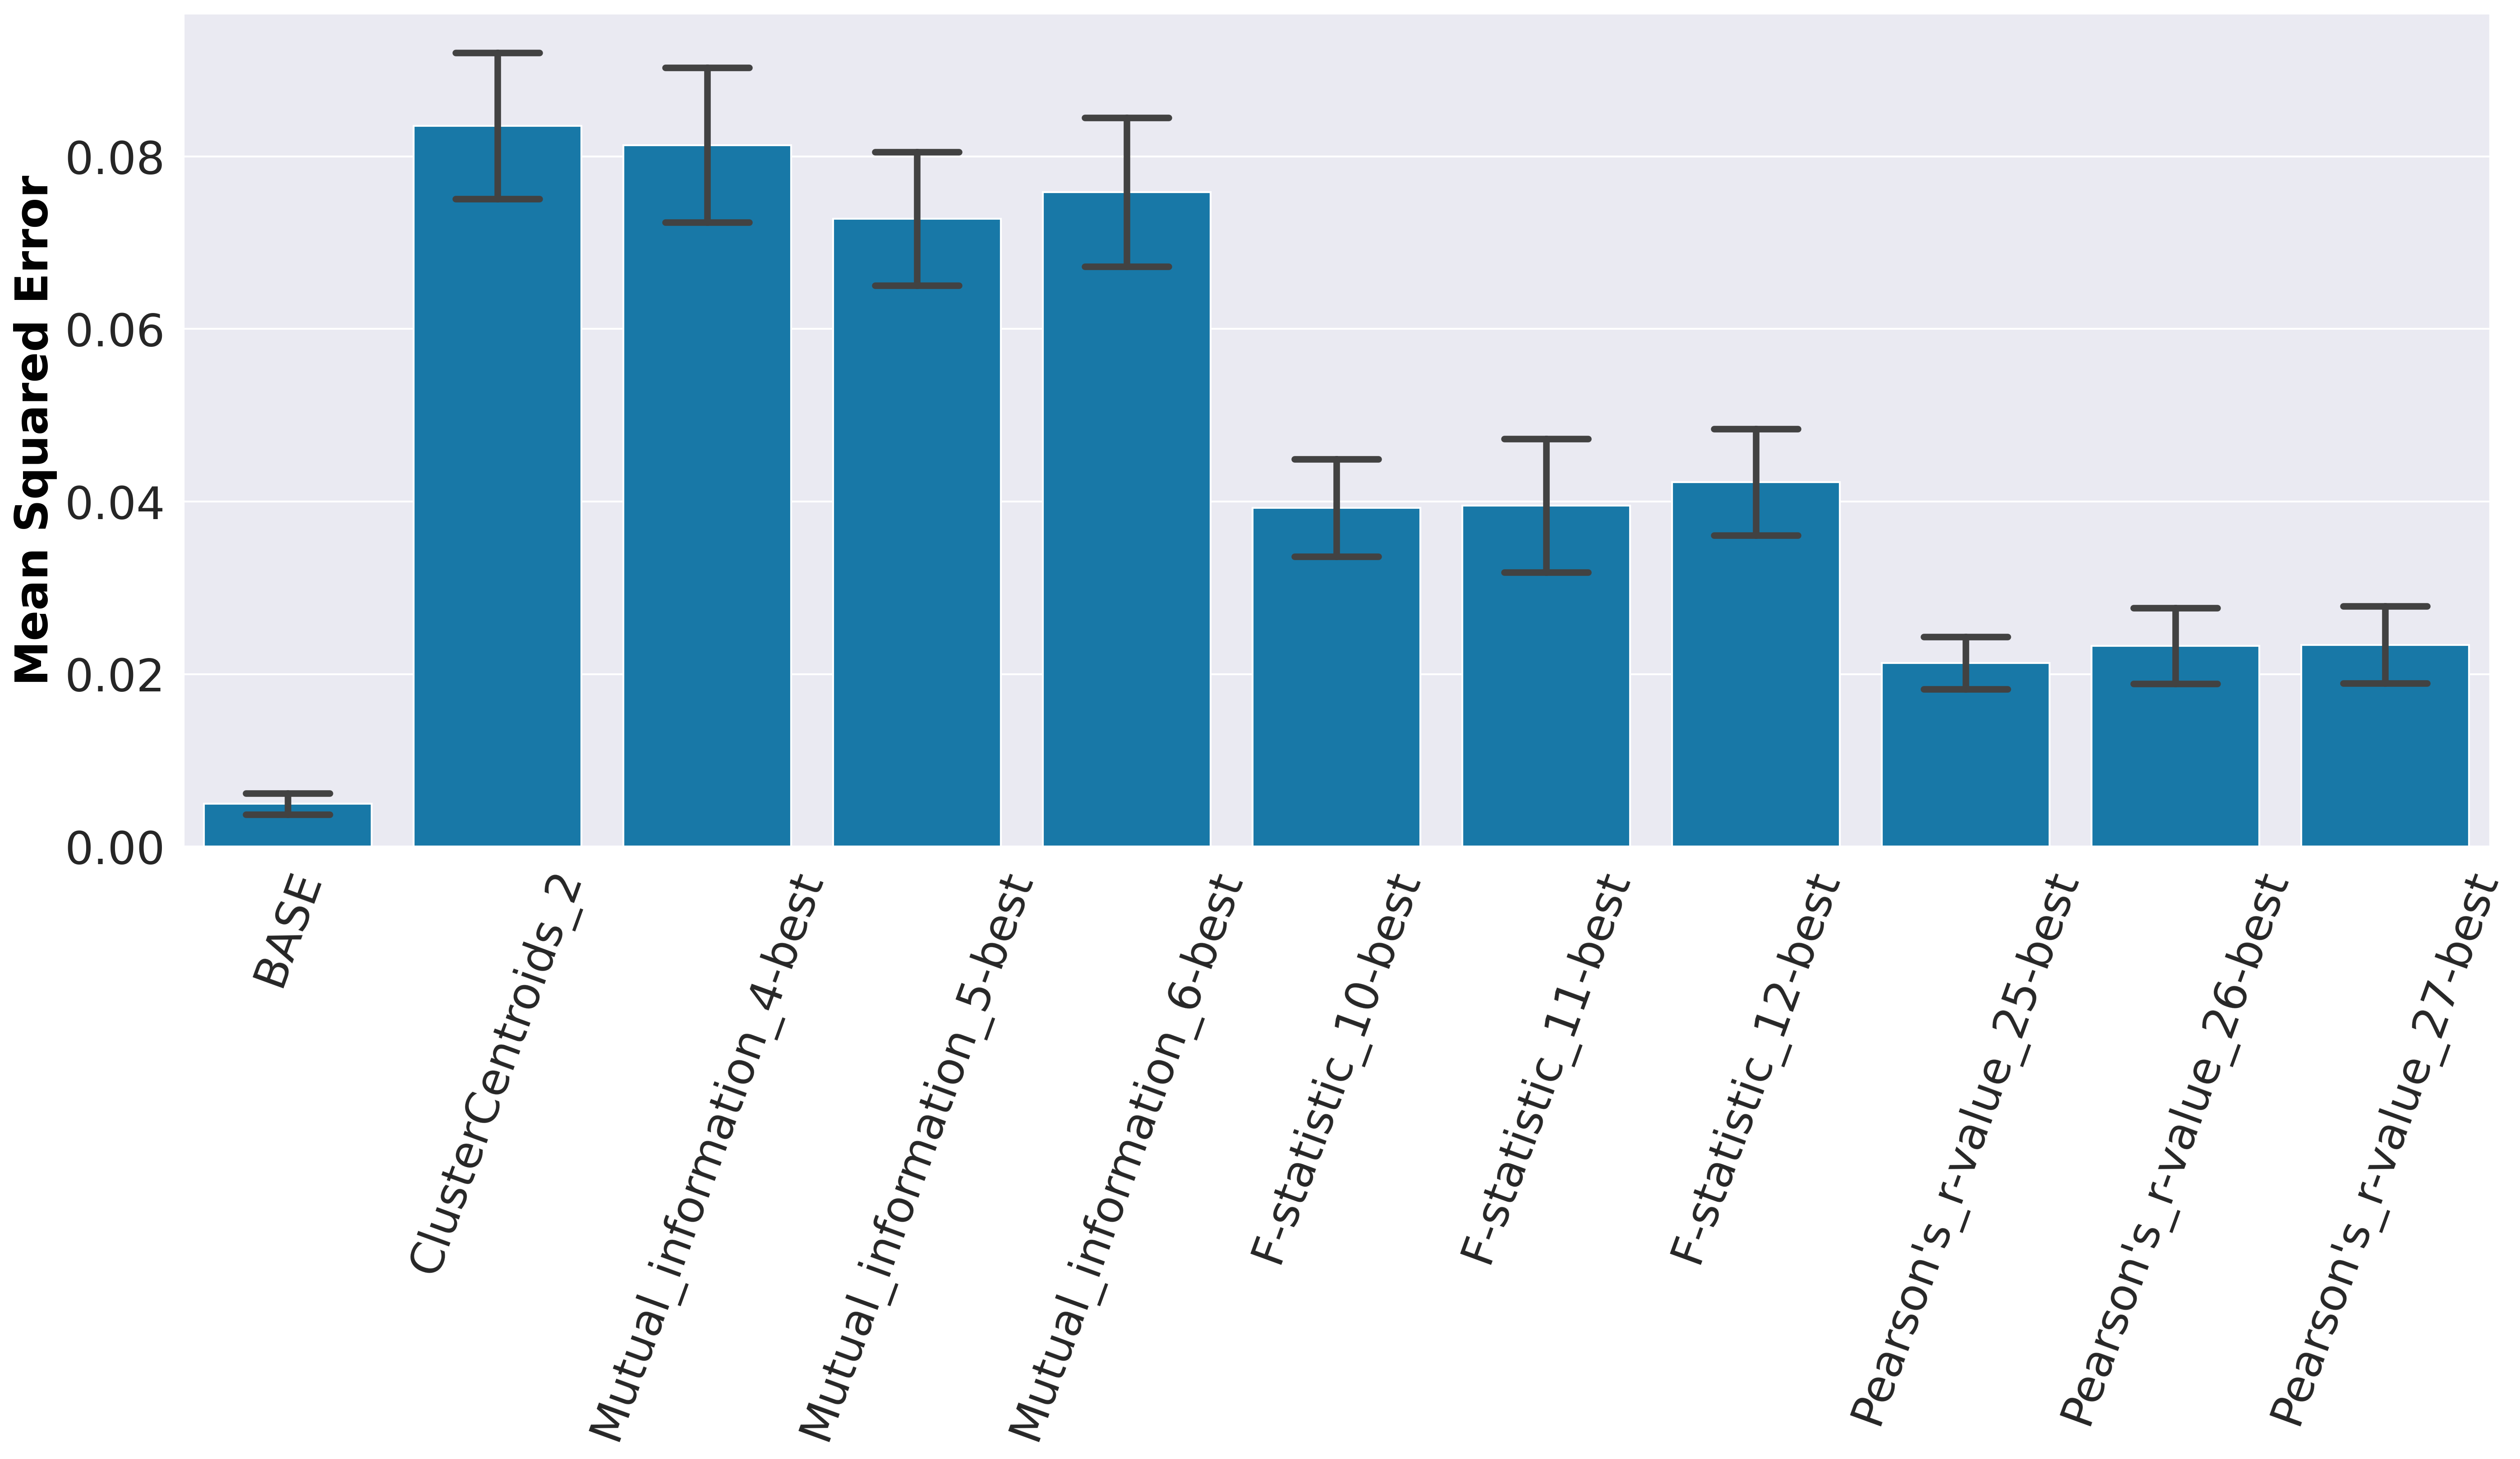

In [11]:
axis_font = {  #'family': 'Times',
    "color": "black",
    "weight": "bold",
    "size": 24,
}

fig = plot_metrics_bar(
    extract_metrics(results, ["test_mse_0.0_40.0"]),
    palette="winter",
    errwidth=3.5,
    capsize=0.4,
)

plt.ylabel("Mean Squared Error", fontdict=axis_font)
plt.xlabel("")
fig.get_legend().remove()

plt.xticks(rotation=70)
fname = Path(RESULT_PATH, r"s50_feature_selection_cc.pdf")
plt.savefig(fname, bbox_inches="tight")
plt.show()

## Plot MSE wrt Defect Size

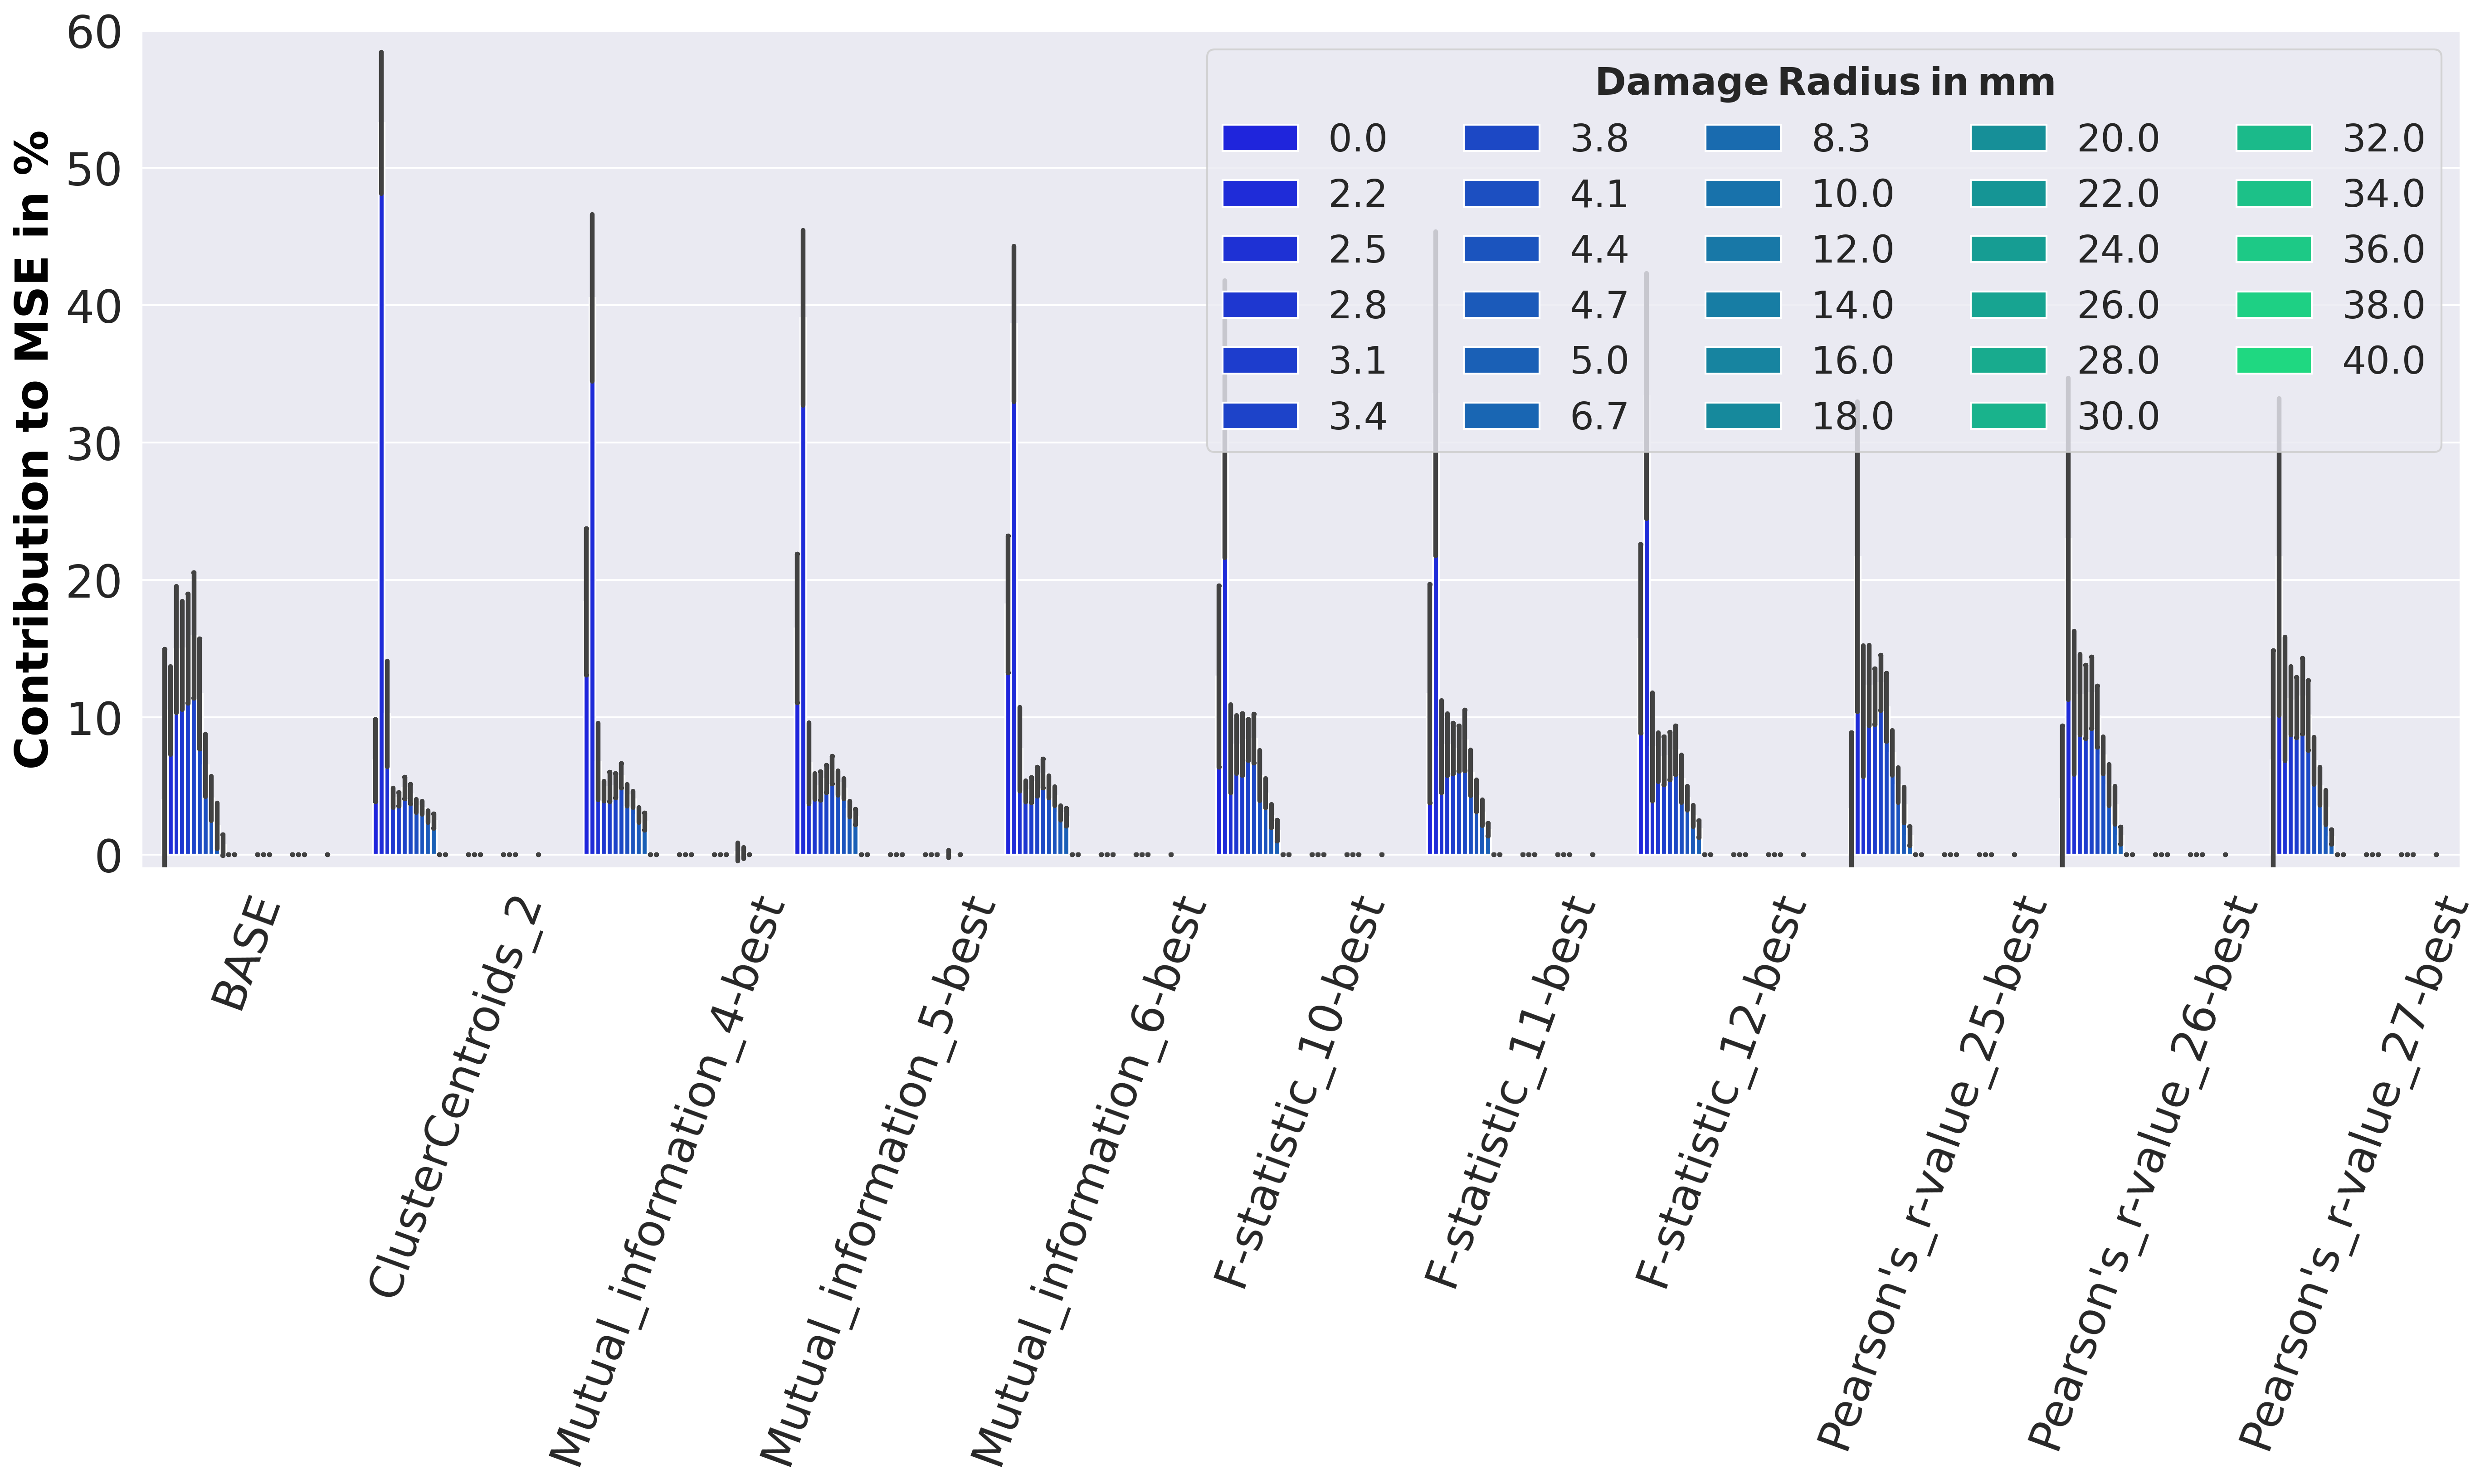

In [12]:
fig = plot_metrics_bar(
    extract_metrics(results, mse_contr_individual),
    palette="winter",
    errwidth=2.5,
    capsize=0.03,
)

plt.ylim((-1, 60))
plt.ylabel("Contribution to MSE in %", fontdict=axis_font)
plt.xlabel("")

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace("mse_contr_", "") for item in labels]
plt.legend(
    handles,
    new_labels,
    ncol=5,
    loc="best",
    title="$\\bf{Damage \:Radius} \:in\:mm$",
    title_fontsize=20,
    fontsize=20,
)

plt.xticks(rotation=70)
fname = Path(RESULT_PATH, r"s50_feature_selection_cc_mse_individual_contribution.pdf")
plt.savefig(fname, bbox_inches="tight")
plt.show()

In [13]:
df = extract_metrics(results, ["test_mse_0.0_40.0"])
print(get_metrics_summary(df))

mean       std
model                     metrics                              
BASE                      test_mse_0.0_40.0  0.004972  0.001226
ClusterCentroids_2        test_mse_0.0_40.0  0.083538  0.008461
F-statistic_10-best       test_mse_0.0_40.0  0.039273  0.005625
F-statistic_11-best       test_mse_0.0_40.0   0.03952  0.007732
F-statistic_12-best       test_mse_0.0_40.0  0.042251  0.006164
Mutual_information_4-best test_mse_0.0_40.0  0.081304  0.008968
Mutual_information_5-best test_mse_0.0_40.0  0.072755  0.007735
Mutual_information_6-best test_mse_0.0_40.0  0.075871  0.008613
Pearson's_r-value_25-best test_mse_0.0_40.0  0.021266  0.003032
Pearson's_r-value_26-best test_mse_0.0_40.0  0.023276  0.004404
Pearson's_r-value_27-best test_mse_0.0_40.0  0.023402  0.004463

## Plot Train/Inference times

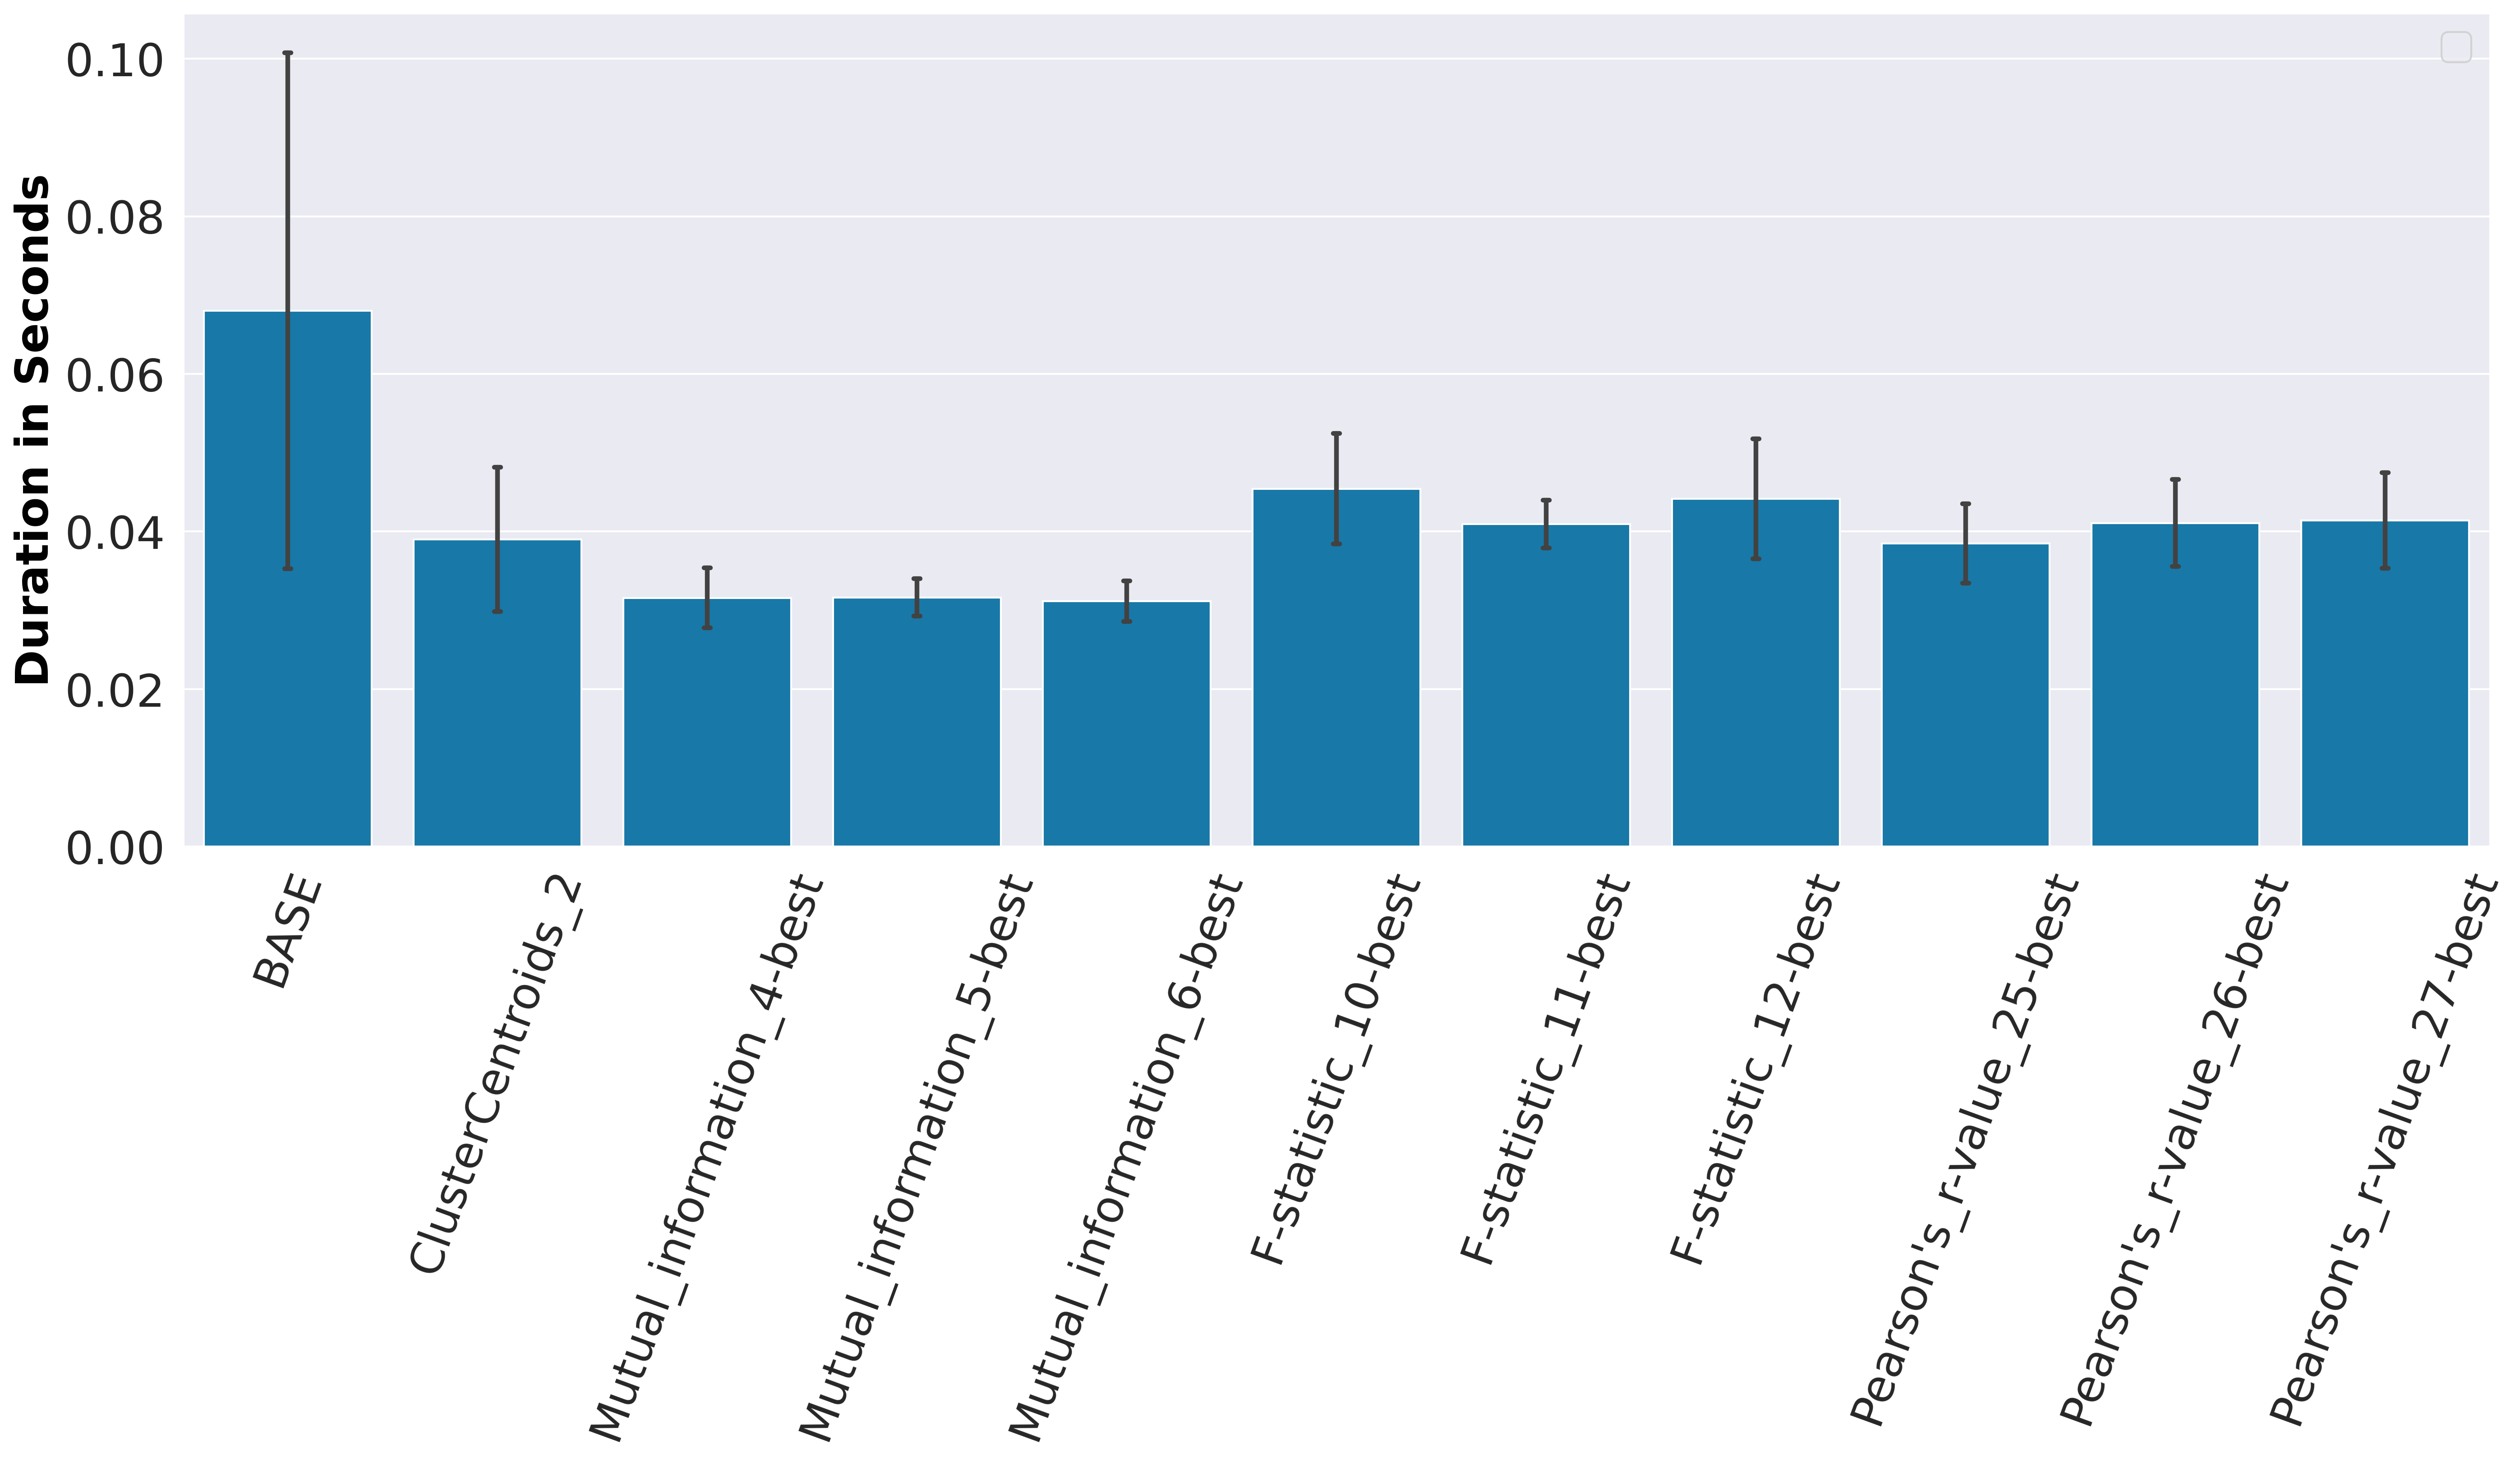

In [14]:
fig = plot_metrics_bar(
    extract_metrics(results, ["score_time"]),
    palette="winter",
    errwidth=2.5,
    capsize=0.03,
)

# plt.ylim((-1, 60))
plt.ylabel("Duration in Seconds", fontdict=axis_font)
plt.xlabel("")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    [],
    ncol=5,
    loc="best",
    title="",
    title_fontsize=20,
    fontsize=20,
)

plt.xticks(rotation=70)
fname = Path(RESULT_PATH, r"s50_feature_selection_cc_time.pdf")
plt.savefig(fname, bbox_inches="tight")
plt.show()

In [15]:
df = extract_metrics(results, ["fit_time", "score_time"])
print(get_metrics_summary(df))

mean       std
model                     metrics                       
BASE                      fit_time    0.014458  0.016338
                          score_time  0.068021  0.032718
ClusterCentroids_2        fit_time    0.079262  0.010693
                          score_time     0.039  0.009143
F-statistic_10-best       fit_time    0.144102  0.017530
                          score_time  0.045431  0.006989
F-statistic_11-best       fit_time    0.150234  0.016620
                          score_time  0.040944  0.003017
F-statistic_12-best       fit_time    0.149494  0.020161
                          score_time  0.044156  0.007625
Mutual_information_4-best fit_time    3.415621  0.299156
                          score_time  0.031574  0.003807
Mutual_information_5-best fit_time    3.243272  0.104440
                          score_time  0.031636  0.002393
Mutual_information_6-best fit_time    3.273656  0.098496
                          score_time  0.031178  0.002573
Pearson's_r-value_25-best fit_time    0.171755  0.016885
                          score_time  0.038477  0.005029
Pearson's_r-value_26-best fit_time    0.170221  0.020200
                          score_time  0.041073  0.005512
Pearson's_r-value_27-best fit_time    0.175728  0.017578
                          score_time  0.041412  0.006073